In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
#data = pd.read_csv('../input/bitstampUSD_1-min_data_2012-01-01_to_2017-10-20.csv')
#data = pd.read_csv('/home/UFF/IA/Trabalho/Dados/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')
data = pd.read_csv('/home/UFF/IA/Trabalho/Dados/Exp10diasVlLow.csv')
data.isnull().values.any()

False

In [3]:
data.head(10)

,DataHora,VlLow
0,2018-06-01 00:00:00,7484.46
1,2018-06-01 00:01:00,7489.73
2,2018-06-01 00:02:00,7491.34
3,2018-06-01 00:03:00,7491.34
4,2018-06-01 00:04:00,7494.01
5,2018-06-01 00:05:00,7498.78
6,2018-06-01 00:06:00,7504.49
7,2018-06-01 00:07:00,7501.13
8,2018-06-01 00:08:00,7503.81
9,2018-06-01 00:09:00,7508.60


In [4]:
#data['date'] = pd.to_datetime(data['Timestamp'],unit='s').dt.date
#group = data.groupby('date')
#Daily_Price = group['Weighted_Price'].mean()
group = data.groupby('DataHora')
Daily_Price = group['VlLow'].mean()
Daily_Price.head()

DataHora
2018-06-01 00:00:00    7484.46
2018-06-01 00:01:00    7489.73
2018-06-01 00:02:00    7491.34
2018-06-01 00:03:00    7491.34
2018-06-01 00:04:00    7494.01
Name: VlLow, dtype: float64

In [5]:
Daily_Price.tail()

DataHora
2018-06-09 23:56:00    7489.10
2018-06-09 23:57:00    7488.00
2018-06-09 23:58:00    7488.38
2018-06-09 23:59:00    7492.40
2018-06-10 00:00:00    7471.67
Name: VlLow, dtype: float64

In [6]:
#from datetime import date
from datetime import datetime

#---- nota: delta.days devolve a diferença em dias excluindo o último dia... 9-1=8 (obvio)
#d0 = date(2016, 1, 1)
#d1 = date(2017, 10, 15)
d0 = datetime(2018, 6, 1, 0, 0, 0) #para extender a 100 dias, usar 2018-03-03
d1 = datetime(2018, 6, 7, 23, 59, 0)
delta = d1 - d0
#days_look = delta.days + 1
days_look = int((delta.days+1)*((delta.seconds/60) + 1))
print(days_look)

#d0 = date(2017, 8, 21)
#d1 = date(2017, 10, 20)
d0 = datetime(2018, 6, 8, 0, 0, 0) #para 10 dias de treinamento , usar 2018-06-02
d1 = datetime(2018, 6, 9, 23, 59, 0)
delta = d1 - d0
#days_from_train = delta.days + 1
days_from_train = int((delta.days+1)*((delta.seconds/60) + 1))
print(days_from_train)

#d0 = date(2017, 10, 15)
#d1 = date(2017, 10, 20)
d0 = datetime(2018, 6, 9, 0, 0, 0)
d1 = datetime(2018, 6, 9, 23, 59, 0)
delta = d1 - d0
#days_from_end = delta.days + 1
days_from_end = int((delta.days+1)*((delta.seconds/60) + 1))
print(days_from_end)

10080
2880
1440


In [7]:
df_train= Daily_Price[len(Daily_Price)-days_look-days_from_end:len(Daily_Price)-days_from_train]
df_test= Daily_Price[len(Daily_Price)-days_from_train:]

print(len(df_train), len(df_test))

8640 2880


In [8]:
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
#working_data['date'] = pd.to_datetime(working_data['date'])
#working_data = working_data.set_index('date')
working_data['DataHora'] = pd.to_datetime(working_data['DataHora'])
working_data = working_data.set_index('DataHora')

In [9]:
#s = sm.tsa.seasonal_decompose(working_data.Weighted_Price.values, freq=60)
s = sm.tsa.seasonal_decompose(working_data.VlLow.values, freq=1440)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

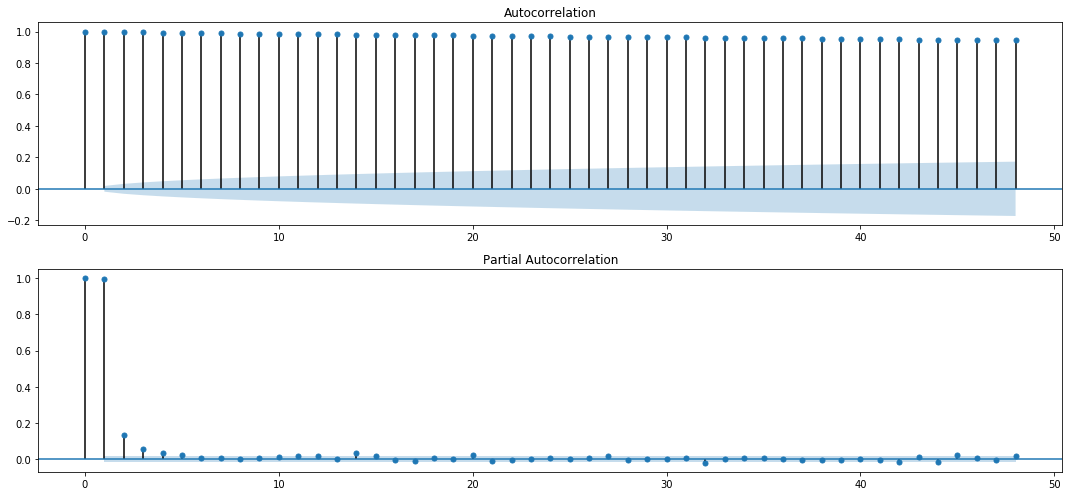

In [10]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
#sm.graphics.tsa.plot_acf(working_data.Weighted_Price.values.squeeze(), lags=48, ax=ax)
sm.graphics.tsa.plot_acf(working_data.VlLow.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(working_data.Weighted_Price.values.squeeze(), lags=48, ax=ax)
sm.graphics.tsa.plot_pacf(working_data.VlLow.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [11]:
#df_train = working_data[:-60]
#df_test = working_data[-60:]
df_train = working_data[:-2880]
df_test = working_data[-2880:]

In [12]:
def create_lookback(dataset, look_back=2): #valor original=1 (dia), agora 1/2 dia = 720 min...
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [13]:
from sklearn.preprocessing import MinMaxScaler

training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

 # reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

In [14]:
# initialize sequential model, add 2 stacked LSTM layers and densely connected output neuron
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Train on 8639 samples, validate on 2879 samples
Epoch 1/100


InternalError: Blas GEMM launch failed : a.shape=(16, 256), b.shape=(256, 256), m=16, n=256, k=256
	 [[{{node lstm_1/while/MatMul_7}} = MatMul[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/AddN_10"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](lstm_1/while/Switch_3:1, lstm_1/while/MatMul_7/Enter)]]
	 [[{{node loss/mul/_111}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3137_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]